# Predictive Maintenance using Machine Learning on Sagemaker
*Part 3 - Model training*

## Initialization
---
Directory structure to run this notebook:
```
sagemaker-predictive-maintenance
|
+--- data
|   |
|   +--- interim: intermediate data we can manipulate and process
|   |
|   \--- raw: *immutable* data downloaded from the source website
|
+--- notebooks: all the notebooks are positionned here
```

### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sagemaker
import pickle as pkl
import boto3
import seaborn as sns
import pandas as pd
import re
import errno

from sagemaker.amazon.amazon_estimator import get_image_uri
from datetime import datetime
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Helper functions
import utils

sns.set_style('darkgrid')

### Loading data from the previous notebook

In [2]:
%store -r

# If the data are not present in the notebook local storage, we need to load them from disk:
success_msg = 'Loaded "data"'
if 'data' not in locals():
    try:
        local_path = '../data/interim'
        data = pd.read_csv(os.path.join(local_path, 'data.csv'))
success_msg    print(success_msg)
            
    except Exception as e:
        if (e.errno == errno.ENOENT):
            print('Files not found to load data from: you need to execute the previous notebook.')
            
else:
    print(success_msg)

Loaded "data"


### Get general information about this SageMaker session

In [3]:
role = sagemaker.get_execution_role()
session = sagemaker.Session()
bucket_name = session.default_bucket()
region = boto3.Session().region_name
prefix = 'nasa_engine_data'

### Set random seed
This will fix the random behavior of all this notebook to ease reproducibility. **Remove this in a production setting.**

In [4]:
import random
random.seed(42)

## Preparing training and validation data
---
As a first step, **we will consider each measurement as an independant event**, irregardless of the unit on which the measure took place. We will not consider this as a timeseries analysis and the two question we want to answer to are the following:

> 1. Given a set of sensor measurements and operation settings, is this unit considered healthy (`label = 0`) or unhealthy (`label = 1` with a `rul` lesser than 30)?
> 2. Given a set of sensor measurements and operation settings, how many cycles does the engine has left (estimating the `rul` column)?

Obviously, this is a big approximation as engine wear down is progressive and each timestep depends from the past behavior measured. We will explore this in a subsequent notebook dedicated to timeseries analysis with services like SageMaker DeepAR built-in algorithm or Amazon Forecast if it makes sense.

### Splitting data

In [5]:
# Extract the features (and convert them to float64 to prevent 
# warning from the scalign step later on) and the target dataframes:
X = data.loc[:, 'operational_setting_1':'sensor_measurement_21'].astype(np.float64)
y_class = data.loc[:, 'label'] # Target value for the classification problem (question #1)
y_reg = data.loc[:, 'rul']     # Target value for the regression problem (question #2)

# Splitting training and validation data for the classification problem:
X_train, X_val, y_class_train, y_class_val = train_test_split(X, y_class, test_size=0.20)

# Applying the same split to the target data for the regression problem:
y_reg_train = y_reg[y_class_train.index]
y_reg_val = y_reg[y_class_val.index]

### Normalizing data
Normalizing the features as they have wildly different ranges. We only need to scale the features as the target can only take two values (0 or 1):

In [6]:
# We build a scaler from the training dataset and apply the same 
# scaler to the validation one. Pay attention that scaling will 
# yield numpy arrays and not Pandas dataframes:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_val_scaled = pd.DataFrame(scaler.fit_transform(X_val))

# No normalization applied on the target data, just putting them in a Pandas Series form:
y_class_train = pd.DataFrame(y_class_train).reset_index(drop=True)
y_class_val = pd.DataFrame(y_class_val).reset_index(drop=True)
y_reg_train = pd.DataFrame(y_reg_train).reset_index(drop=True)
y_reg_val = pd.DataFrame(y_reg_val).reset_index(drop=True)

# This exact same scaler will have to be used again on the testing 
# data before feeding them to the model. Let's persist it on S3:
joblib.dump(scaler, 'MinMaxScaler.joblib')
session.upload_data(path='MinMaxScaler.joblib', bucket=bucket_name, key_prefix='{}/preprocessing'.format(prefix))

's3://sagemaker-eu-west-1-123031033346/nasa_engine_data/preprocessing/MinMaxScaler.joblib'

### Uploading to S3

The XGBoost algorithm we want to use needs a dataset with the **target values in the first column** and the features in the remaining ones. Moreover, we want to **remove any header or index** from the dataframe. Let's assemble our training and validation datasets like this before uploading them to S3:

In [7]:
# Saving datasets to disk:
pd.concat([y_class_train, X_train_scaled], axis='columns').to_csv('training_classification.csv', header=False, index=False)
pd.concat([y_class_val, X_val_scaled], axis='columns').to_csv('validation_classification.csv', header=False, index=False)

pd.concat([y_reg_train, X_train_scaled], axis='columns').to_csv('training_regression.csv', header=False, index=False)
pd.concat([y_reg_val, X_val_scaled], axis='columns').to_csv('validation_regression.csv', header=False, index=False)

# Uploading them to S3:
session.upload_data(path='training_classification.csv', bucket=bucket_name, key_prefix='{}/input'.format(prefix));
session.upload_data(path='validation_classification.csv', bucket=bucket_name, key_prefix='{}/input'.format(prefix));

session.upload_data(path='training_regression.csv', bucket=bucket_name, key_prefix='{}/input'.format(prefix));
session.upload_data(path='validation_regression.csv', bucket=bucket_name, key_prefix='{}/input'.format(prefix));

# Cleanup: remove the local files once uploaded:
os.remove('training_classification.csv')
os.remove('validation_classification.csv')
os.remove('training_regression.csv')
os.remove('validation_regression.csv')

## Model training
---
### Model 1: classification problem: *is my engine healthy?*
Encapsulating inputs in S3 object to ensure content type (text/csv in this case) is correctly identified by the algorithm:

In [8]:
s3_input_class_train = sagemaker.s3_input(s3_data='s3://{}/{}/input/training_classification.csv'.format(bucket_name, prefix), content_type='text/csv')
s3_input_class_val = sagemaker.s3_input(s3_data='s3://{}/{}/input/validation_classification.csv'.format(bucket_name, prefix), content_type='text/csv')

Build an `Estimator` object that will be used to train the model afterward:

In [9]:
# Fetch the training container for SageMaker built-in XGBoost algorithm:
xgb_container = get_image_uri(region, 'xgboost', '0.90-1')

# Build a training job name:
training_job_name = 'xgboost-nasa-health-class'

# Build the estimator object:
model_artifacts_path = 's3://{}/{}/output'.format(bucket_name, prefix)
xgb_estimator = sagemaker.estimator.Estimator(
    image_name=xgb_container,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    output_path=model_artifacts_path,
    sagemaker_session=session,
    base_job_name=training_job_name
)

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. For XGBoost they can be found in the [Amazon SageMaker developer guide](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html):

In [10]:
# Link hyperparameters to this estimator:
xgb_estimator.set_hyperparameters(
    max_depth=6,                   # Max depth of a given tree
    eta=0.3,                       # Step size shrinkage used in updates to prevent overfitting
    gamma=0,                       # Minimum loss reduction required to make a further partition on a leaf node of the tree
    min_child_weight=1,            # Minimum sum of instance weight (hessian) needed in a child
    subsample=1.0,                 # Subsample ratio of the training instance
    silent=0,                      # 0 means print running messages
    #objective='reg:squarederror', # Learning task and learning objective
    objective='binary:logistic',   # Learning task and learning objective
    
    num_round=40                   # The number of rounds to run the training
)

# This model is better (the default values overfit quite severely but it will do for the hyperparameter tuning demonstration later on)
#xgb_estimator.set_hyperparameters(
#    max_depth=3,                   # Max depth of a given tree
#    eta=0.2,                       # Step size shrinkage used in updates to prevent overfitting
#    gamma=5,                       # Minimum loss reduction required to make a further partition on a leaf node of the tree
#    min_child_weight=6,            # Minimum sum of instance weight (hessian) needed in a child
#    subsample=0.5,                 # Subsample ratio of the training instance
#    silent=0,                      # 0 means print running messages
#    #objective='reg:squarederror', # Learning task and learning objective
#    objective='binary:logistic',   # Learning task and learning objective
#    num_round=40                   # The number of rounds to run the training
#)

Launch training:

In [11]:
xgb_estimator.fit({'train': s3_input_class_train, 'validation': s3_input_class_val})

2020-05-15 06:41:16 Starting - Starting the training job...
2020-05-15 06:41:17 Starting - Launching requested ML instances...
2020-05-15 06:42:16 Starting - Preparing the instances for training.........
2020-05-15 06:43:24 Downloading - Downloading input data...
2020-05-15 06:44:17 Training - Training image download completed. Training in progress...INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[06:44:19] 16504x17 matrix with 280568 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:r

Plot training metrics: the metrics are stored in the Amazon Cloudwatch Logs service. Check the `get_training_metrics()` helper functions in the `utils.py` module for more details:

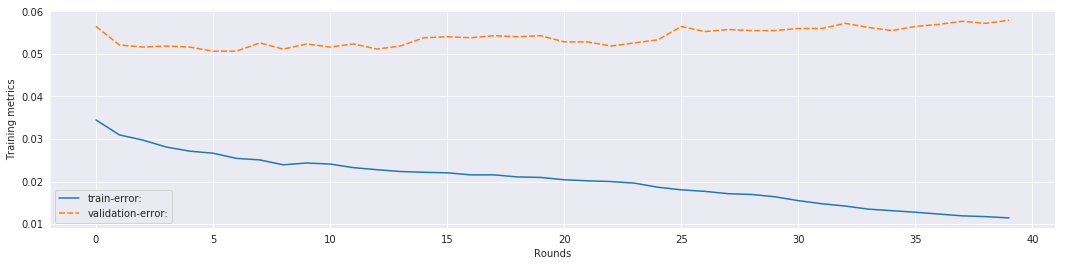

In [12]:
# Extract the metrics from the Cloudwatch logs:
metrics_df = utils.get_training_metrics(xgb_estimator.latest_training_job.name, 'train-error:', 'validation-error:')

# Plot the metrics:
fig1 = plt.figure(figsize=(18,4))
chart = sns.lineplot(data=metrics_df)
chart.set_ylabel('Training metrics');
chart.set_xlabel('Rounds');

This model with default values for XGBoost hyperparameters clearly demonstrates severe overfitting. We will address this in the hyperparameter tuning notebook, but this will give us a baseline to improve from.

### Model 2: regression problem: *how long does my engine still has before break up?*
Encapsulating inputs in S3 object to ensure content type (text/csv in this case) is correctly identified by the algorithm:

In [13]:
s3_input_reg_train = sagemaker.s3_input(s3_data='s3://{}/{}/input/training_regression.csv'.format(bucket_name, prefix), content_type='text/csv')
s3_input_reg_val = sagemaker.s3_input(s3_data='s3://{}/{}/input/validation_regression.csv'.format(bucket_name, prefix), content_type='text/csv')

Build an `Estimator` object that will be used to train the model afterward:

In [14]:
# Build a training job name:
training_job_name = 'xgboost-nasa-rul-reg'

# Build the estimator object:
model_artifacts_path = 's3://{}/{}/output'.format(bucket_name, prefix)
xgb_estimator2 = sagemaker.estimator.Estimator(
    image_name=xgb_container,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    output_path=model_artifacts_path,
    sagemaker_session=session,
    base_job_name=training_job_name
)

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. For XGBoost they can be found in the [Amazon SageMaker developer guide](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html):

In [15]:
# Link hyperparameters to this estimator:
xgb_estimator2.set_hyperparameters(
    max_depth=6,                   # Max depth of a given tree
    eta=0.3,                       # Step size shrinkage used in updates to prevent overfitting
    gamma=0,                       # Minimum loss reduction required to make a further partition on a leaf node of the tree
    min_child_weight=1,            # Minimum sum of instance weight (hessian) needed in a child
    subsample=1.0,                 # Subsample ratio of the training instance
    silent=0,                      # 0 means print running messages
    objective='reg:squarederror', # Learning task and learning objective
    num_round=40                   # The number of rounds to run the training
)

Launch training:

In [16]:
xgb_estimator2.fit({'train': s3_input_reg_train, 'validation': s3_input_reg_val})

2020-05-15 06:44:58 Starting - Starting the training job...
2020-05-15 06:45:00 Starting - Launching requested ML instances......
2020-05-15 06:46:00 Starting - Preparing the instances for training...
2020-05-15 06:46:51 Downloading - Downloading input data...
2020-05-15 06:47:27 Training - Downloading the training image...
2020-05-15 06:47:54 Uploading - Uploading generated training model
2020-05-15 06:47:54 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[06:47:44] 16504x17 matrix with 

Plot training metrics: the metrics are stored in the Amazon Cloudwatch Logs service. Check the `get_training_metrics()` helper functions in the `utils.py` module for more details:

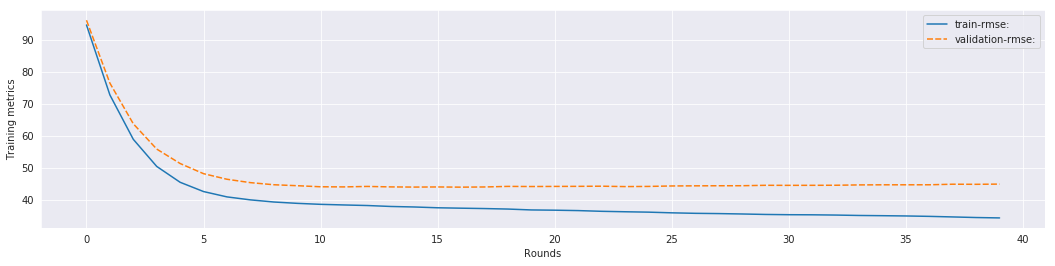

In [17]:
# Extract the metrics from the Cloudwatch logs:
metrics_df = utils.get_training_metrics(xgb_estimator2.latest_training_job.name, 'train-rmse:', 'validation-rmse:')

# Plot the metric:
fig2 = plt.figure(figsize=(18,4))
chart = sns.lineplot(data=metrics_df)
chart.set_ylabel('Training metrics');
chart.set_xlabel('Rounds');

With default values for XGBoost hyperparameters, this regression model also demonstrates some overfitting. We will address this in the hyperparameter tuning notebook, but this will give us a baseline to improve from.

### Feature importance
To get the feature importance, we need to download first the model artifacts stored during the training on S3. Let's get it for the last model trained (the regression problem):

In [18]:
model_artifacts_key = 'nasa_engine_data/output/{}/output/model.tar.gz'.format(xgb_estimator2._current_job_name)
print('Downloading model artifacts from s3://{}/{}'.format(bucket_name, model_artifacts_key))
s3_client = boto3.Session().resource('s3')
s3_client.Bucket(bucket_name).download_file(model_artifacts_key, 'model.tar.gz')
!tar -xzf model.tar.gz
!rm model.tar.gz

XGBoost is installed in the training container we used previously. It is not installed by default on the notebook instance. Installing the open source XGBoost module (with the same version as the latest built-in SageMaker one):

In [19]:
!pip install xgboost==0.90

    100% |████████████████████████████████| 142.8MB 357kB/s eta 0:00:01   51% |████████████████▌               | 73.7MB 76.0MB/s eta 0:00:01    68% |██████████████████████          | 98.2MB 73.3MB/s eta 0:00:01
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Load the model into a booster object:

In [20]:
booster = pkl.load(open('xgboost-model', 'rb'))
!rm xgboost-model

Get feature importance from the XGBoost model:

In [21]:
fscores = booster.get_fscore()
feature_importance = pd.DataFrame(columns=['feature', 'score'])
for feature in fscores:
    index = int(feature[1:])
    feature_importance = feature_importance.append({
        'feature': X_train.columns.tolist()[index],
        'score': fscores[feature]
    }, ignore_index=True)
    
feature_importance = feature_importance.sort_values(by='score', ascending=False)

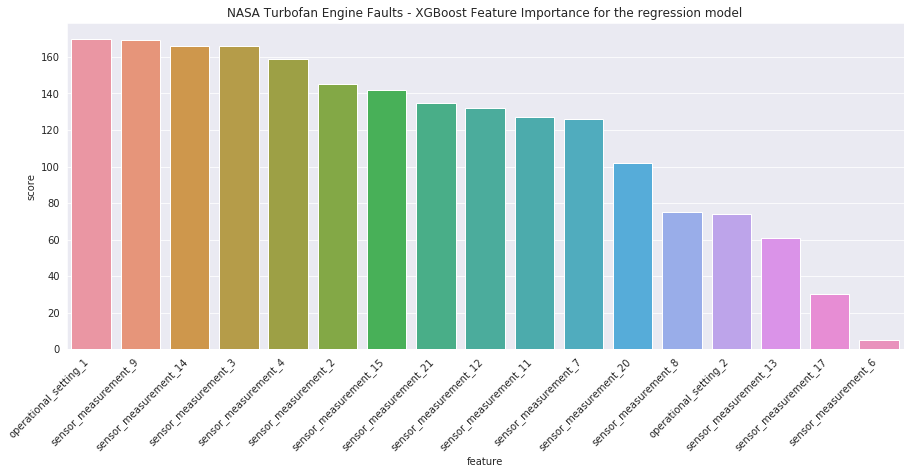

In [22]:
fig3 = plt.figure(figsize=(15,6))
chart = sns.barplot(x='feature', y='score', data=feature_importance)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');
chart.set_title('NASA Turbofan Engine Faults - XGBoost Feature Importance for the regression model');

## Cleanup
---

In [23]:
fig1.clear()
fig2.clear()
fig3.clear()
plt.close(fig1)
plt.close(fig2)
plt.close(fig3)

### Storing data for the next notebook

In [24]:
xgb_classification_job = xgb_estimator.latest_training_job.name
xgb_regression_job = xgb_estimator2.latest_training_job.name
%store X_train
%store xgb_classification_job
%store xgb_regression_job

Stored 'X_train' (DataFrame)
Stored 'xgb_classification_job' (str)
Stored 'xgb_regression_job' (str)


### Persisting these data to disk
This is useful in case you want to be able to execute each notebook independantly (from one session to another) and don't want to reexecute every notebooks whenever you want to focus on a particular step.

In [25]:
# Create the local path for our artifacts:
local_path = '../data/interim'
os.makedirs(local_path, exist_ok=True)

# Write the updated dataframe:
X_train.to_csv(os.path.join(local_path, 'X_train.csv'), index=False)

# Write the training job names:
with open(os.path.join(local_path, 'job_names.txt'), 'w') as f:
    f.write(xgb_classification_job + '\n')
    f.write(xgb_regression_job)